In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
%matplotlib inline

In [3]:
NAME_REGEX = r"((checkpoint|events|args).*)|report-dev-m(?P<d>[^-]*(start-with-beams)?(,,overfit=[a-z_]*)?)-(?P<s>[0-9]*)-(?P<t>train|eval|real)\.jsonl$"

In [4]:
def table_of_accuracies(label):
    print(label)
    [logdir] = glob.glob("../logdirs/{},*".format(label))
    data = []
    for f in os.listdir(logdir):
        if not f.endswith(".jsonl"): continue
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if m.group("d") is None:
            print(m)
            1/0
            continue
        data_source = m.group("t")
        data_label = m.group("d")
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(logdir, f)) as fp:
            try:
                stats = json.loads(next(fp))
            except StopIteration:
                stats = None
        if stats is None or not stats.get('done', stats['total'] >= 2500):
            print(os.path.join(logdir, f))
            print(stats)
            continue
        
        data.append([label, checkpoint, stats['correct'] / stats['total'], stats['total'], data_source, data_label])
    df = pd.DataFrame(
        data, columns=['Model', 'Step', 'Accuracy', 'Total', 'DataSource', 'DataLabel']
    )
    return df


In [5]:
model_labels = """
vanilla
aggregate-standard
aggregate-with-io
#vanilla-real-nearai
#aggregate-with-io-real-nearai
vanilla-real-nearai-finetuned-1e-4
aggregate-with-io-real-nearai-finetuned-1e-4
# vanilla-real-nearai-finetuned-rl-1e-5
# aggregate-with-io-real-nearai-finetuned-rl-1e-5
vanilla-many-mutations
aggregate-with-io-many-mutations
# vanilla-real-nearai-finetuned-rl-1e-5-use-heldout
# aggregate-with-io-real-nearai-finetuned-rl-1e-5-use-heldout
vanilla-real-nearai-finetuned-1e-5
aggregate-with-io-real-nearai-finetuned-1e-5
""".strip().split("\n")
model_labels = [x for x in model_labels if x[0] != '#']

In [6]:
accuracies = [table_of_accuracies(x) for x in model_labels]
accuracies = pd.concat(accuracies)

vanilla
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-mnearai32,,best_first,,25,,overfit=overfit_awoi_all_beams_balanced_load_debugger-1750100-real.jsonl
{'total': 24, 'correct': 20, 'syntax-error': 0, 'runtime-exception': 0, 'done': False}
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-mnearai32,,best_first,,25,,start-with-beams,,overfit=overfit_aggregate_with_io_slow_split-1750100-real.jsonl
{'total': 416, 'correct': 347, 'syntax-error': 0, 'runtime-exception': 1, 'done': False}
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-mnearai32,,best_first,,25,,overfit=overfit_aggregate_with_io_slow_split-1750100-real.jsonl
{'total': 416, 'correct': 332, 'syntax-error': 0, 'runtime-exception': 4, 'done': False}
../logdirs/vanilla,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-mnearai32,,best_first,,25,,overfit=overfit_aggregate_with_io_slow_split

aggregate-with-io-real-nearai-finetuned-1e-5
../logdirs/aggregate-with-io-real-nearai-finetuned-1e-5,data=nearai,pretr=aggregate-with-io,,1028500,trace_enc==aggregate:conv_all_grids=True,batch_size==64,lr==0.00001,lr_decay_steps=100000/report-dev-mnearai32,,best_first,,25,,overfit=overfit_awoi_all_beams_balanced_load_debugger-51000-real.jsonl
{'total': 1440, 'correct': 1162, 'syntax-error': 0, 'runtime-exception': 8, 'done': False}


In [7]:
accuracies

,Model,Step,Accuracy,Total,DataSource,DataLabel
0,vanilla,850100,0.160271,443,real,"nearai32,,greedy,,5"
1,vanilla,250100,0.457459,905,real,"nearai,,best_first,,25"
2,vanilla,1750100,0.401105,905,real,"nearai,,best_first,,5"
3,vanilla,1550100,0.478453,905,real,"nearai,,greedy,,25"
4,vanilla,50100,0.033860,443,real,"nearai32,,greedy,,1"
...,...,...,...,...,...,...
213,aggregate-with-io-real-nearai-finetuned-1e-5,21000,0.918254,2520,train,"0,0,1"
214,aggregate-with-io-real-nearai-finetuned-1e-5,41000,0.194131,443,real,"nearai32,,best_first,,5"
215,aggregate-with-io-real-nearai-finetuned-1e-5,51000,0.417680,905,real,"nearai,,best_first,,5,,start-with-beams"
216,aggregate-with-io-real-nearai-finetuned-1e-5,21000,0.291196,443,real,"nearai32,,best_first,,25"


In [8]:
acs = accuracies[accuracies.DataLabel.map(lambda x: 'nearai,' in x and ',,overfit=' not in x)].copy()
acs.Accuracy *= acs.Total
acs.Accuracy += 2500 - 975
acs.Accuracy /= 2500
acs = pd.concat([acs, accuracies[accuracies.DataLabel.map(lambda x: 'nearai,' in x and ',,overfit=' in x)].copy()])
acs = acs[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
acs.sort_values('Accuracy')

,Model,Step,DataLabel,Accuracy
259,vanilla-many-mutations,50100,"nearai,,best_first,,1",0.6620
621,vanilla-many-mutations,50100,"nearai,,greedy,,1",0.6620
834,vanilla,50100,"nearai,,greedy,,1",0.6620
337,vanilla,50100,"nearai,,best_first,,1",0.6620
507,aggregate-standard,50100,"nearai,,greedy,,1",0.6696
...,...,...,...,...
2,aggregate-with-io-real-nearai-finetuned-1e-4,250100,"nearai,,best_first,,25",0.8144
24,vanilla-real-nearai-finetuned-1e-4,150100,"nearai,,best_first,,25",0.8172
7,vanilla-real-nearai-finetuned-1e-4,150100,"nearai,,best_first,,25,,start-with-beams",0.8172
107,aggregate-with-io-real-nearai-finetuned-1e-4,262200,"nearai,,best_first,,25,,start-with-beams",0.8184


In [9]:
acs = accuracies[accuracies.DataLabel.map(lambda x: 'nearai32,' in x and ",,overfit=" not in x)].copy()
acs.Accuracy *= acs.Total
acs.Accuracy += 1950
acs.Accuracy /= 2500
acs = pd.concat([acs, accuracies[accuracies.DataLabel.map(lambda x: 'nearai32,' in x and ",,overfit=" in x)].copy()])
acs = acs[['Model', 'Step', 'DataLabel', 'Accuracy']].copy()
best_nearai32 = acs.sort_values('Accuracy')
best_nearai32.iloc[-50:]

,Model,Step,DataLabel,Accuracy
841,vanilla,1450100,"nearai32,,best_first,,25,,start-with-beams",0.839600
319,aggregate-with-io,200100,"nearai32,,best_first,,25,,start-with-beams",0.839600
128,aggregate-with-io,250100,"nearai32,,best_first,,25,,start-with-beams",0.839600
475,vanilla,700100,"nearai32,,best_first,,25,,start-with-beams,,ov...",0.839872
192,vanilla-real-nearai-finetuned-1e-4,200100,"nearai32,,best_first,,25,,start-with-beams,,ov...",0.839872
252,vanilla-real-nearai-finetuned-1e-5,251000,"nearai32,,best_first,,25,,start-with-beams",0.840000
166,aggregate-with-io-real-nearai-finetuned-1e-4,150100,"nearai32,,best_first,,25,,start-with-beams",0.840000
390,vanilla,1100100,"nearai32,,best_first,,25,,start-with-beams",0.840000
900,vanilla,1400100,"nearai32,,best_first,,25,,start-with-beams",0.840000
170,aggregate-standard,1043700,"nearai32,,best_first,,25,,start-with-beams",0.840000


In [10]:
max_step = accuracies.groupby(list(set(accuracies) - {'Step', 'Accuracy'})).transform(max).Step
just_max_step = accuracies[accuracies.Step == max_step]

In [11]:
def get_accuracies(model, data_source, data_label=None):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataLabel', values='Accuracy')
def plot_combined_accuracy(table, label):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()

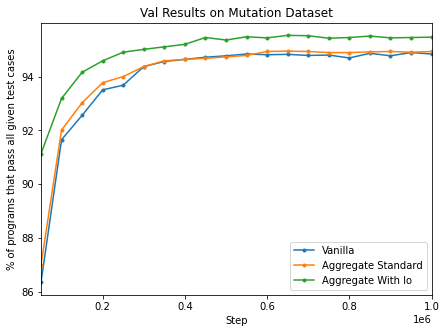

In [12]:
# temporary for thesis draft
plt.figure(figsize=(7, 5))
plt.title("Val Results on Mutation Dataset")
for model in "vanilla", "aggregate-standard", "aggregate-with-io":
    plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

plt.xlim(5 * 10 ** 4, 10 ** 6)
plt.ylabel("% of programs that pass all given test cases")
plt.show()

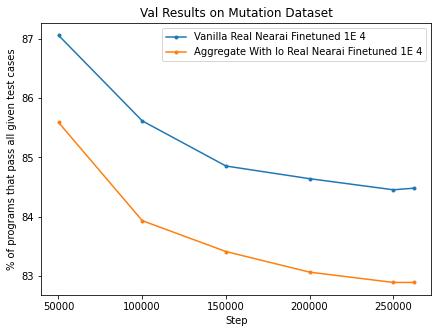

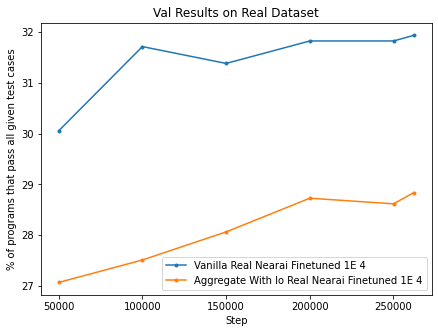

In [13]:
# temporary for thesis draft
plt.figure(figsize=(7, 5))
plt.title("Val Results on Mutation Dataset")
for model in model_labels:
    if "finetuned" in model and "1e-4" in model:
        plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

plt.ylabel("% of programs that pass all given test cases")
plt.show()
plt.figure(figsize=(7, 5))
plt.title("Val Results on Real Dataset")
for model in model_labels:
    if "finetuned" in model and "1e-4" in model:
        plot_combined_accuracy(get_accuracies(model, 'real', 'nearai'), model.replace('-', ' ').title())

plt.ylabel("% of programs that pass all given test cases")
plt.show()

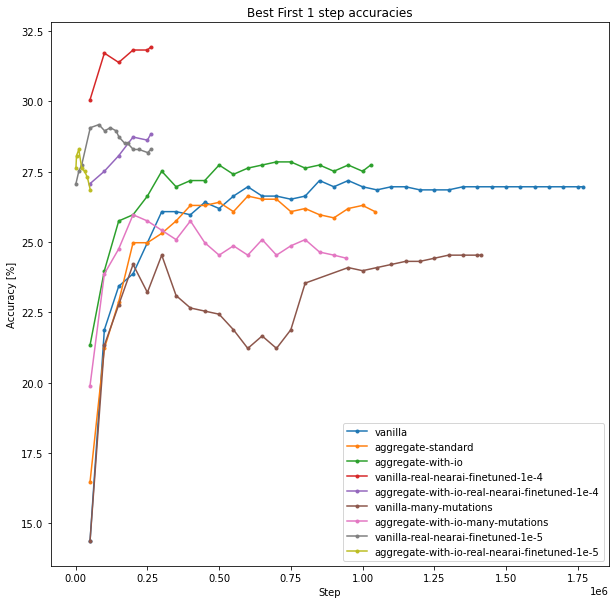

In [14]:
plt.figure(figsize=(10, 10))
plt.title("Best First 1 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,1'), model)

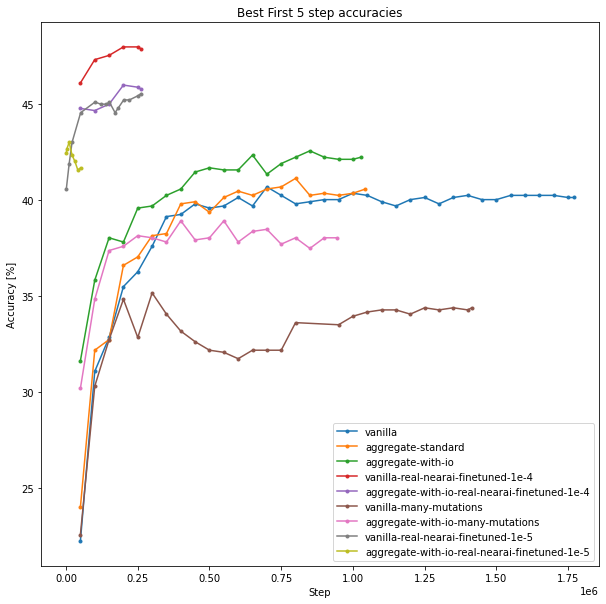

In [15]:
plt.figure(figsize=(10, 10))
plt.title("Best First 5 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,5'), model)

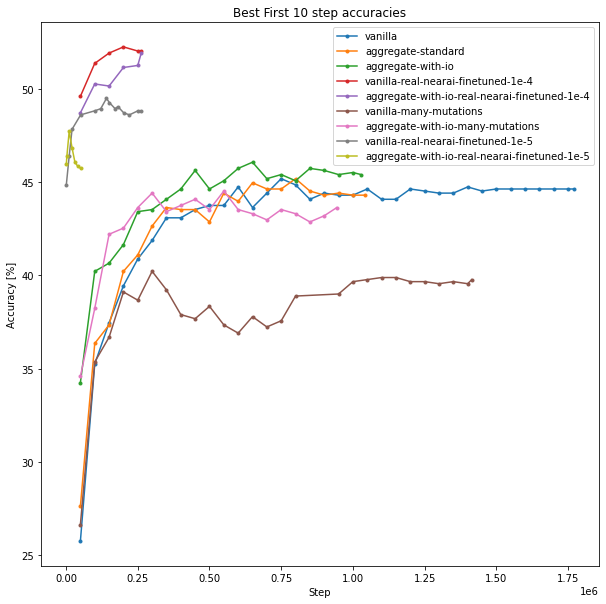

In [16]:
plt.figure(figsize=(10, 10))
plt.title("Best First 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,10'), model)

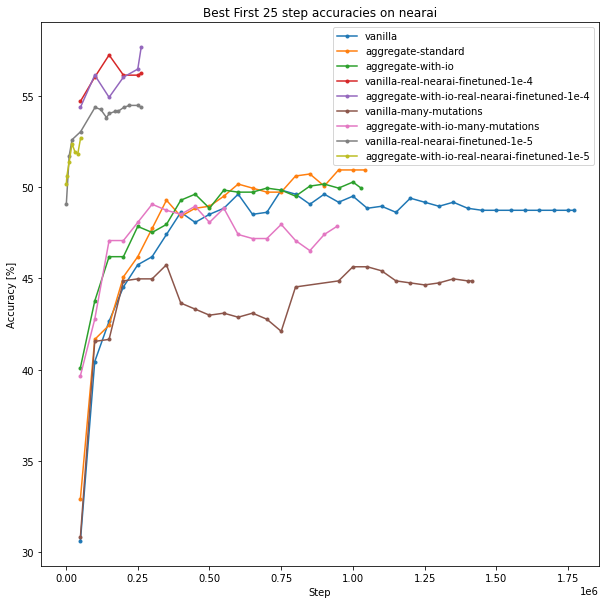

In [17]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,25'), model)

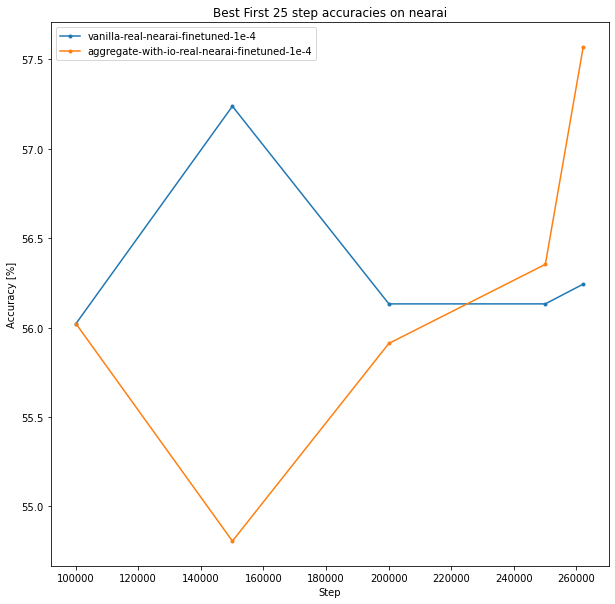

In [18]:
# temporary for thesis
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai")
for model in model_labels:
    if "finetuned-1e-4" in model:
        plot_combined_accuracy(get_accuracies(model, 'real', 'nearai,,best_first,,25,,start-with-beams'), model)

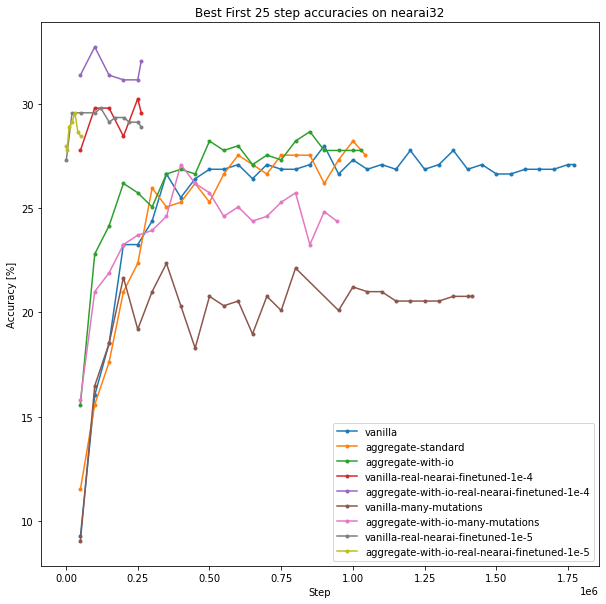

In [19]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai32")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai32,,best_first,,25'), model)

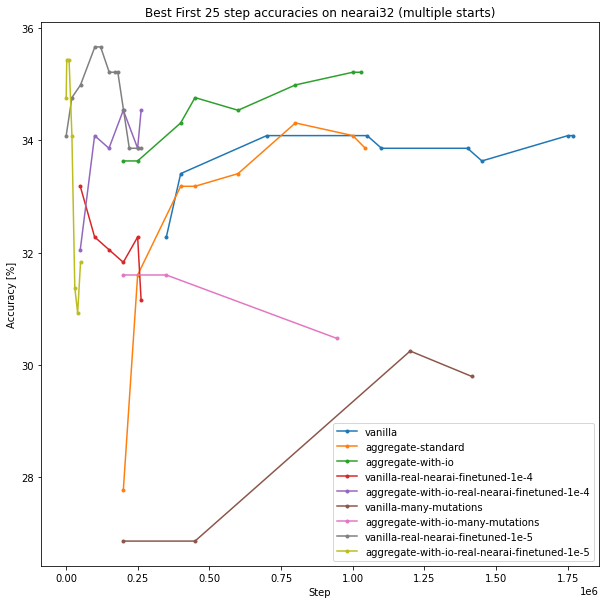

In [20]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai32 (multiple starts)")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai32,,best_first,,25,,start-with-beams'), model)

In [21]:
accuracies[
    (accuracies.DataLabel == 'nearai32,,best_first,,25,,start-with-beams,,overfit=overfit_vanilla_slow_split')
    & (accuracies.Model == 'vanilla')
].sort_values('Accuracy')

,Model,Step,Accuracy,Total,DataSource,DataLabel
22,vanilla,350100,0.836669,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."
909,vanilla,1400100,0.839071,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."
119,vanilla,1050100,0.839472,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."
665,vanilla,1750100,0.839472,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."
911,vanilla,1769300,0.839472,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."
475,vanilla,700100,0.839872,2498,real,"nearai32,,best_first,,25,,start-with-beams,,ov..."


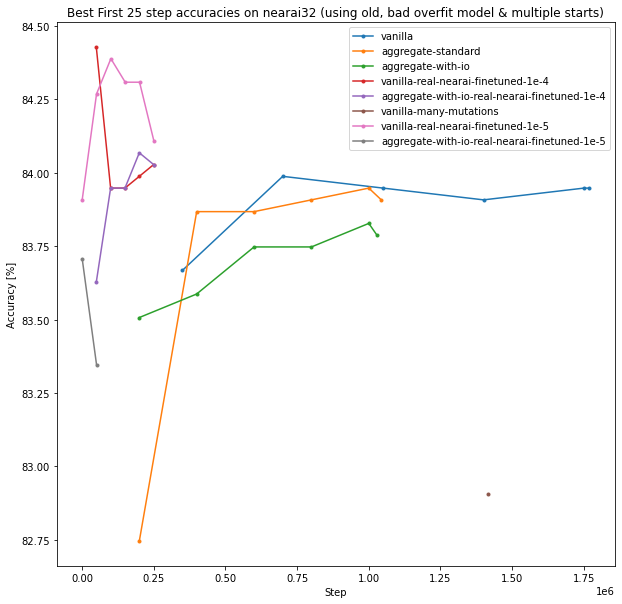

In [25]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies on nearai32 (using old, bad overfit model & multiple starts)")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'nearai32,,best_first,,25,,start-with-beams,,overfit=overfit_vanilla_slow_split'), model)

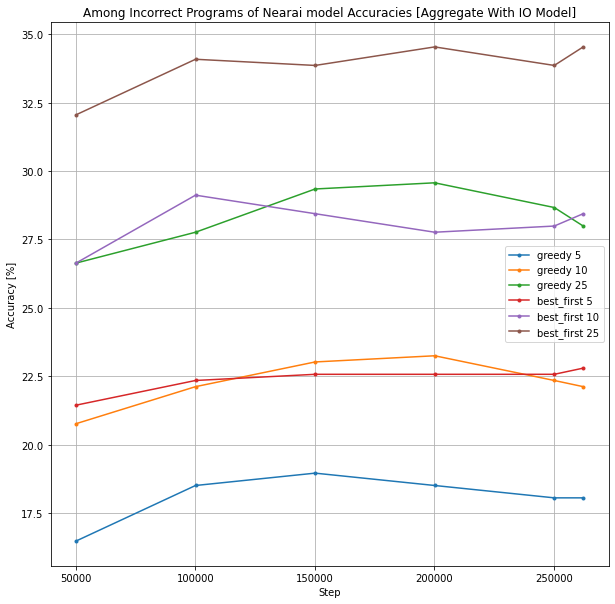

In [23]:
# temporary for thesis
plt.figure(figsize=(10, 10))
plt.title("Among Incorrect Programs of Nearai model Accuracies [Aggregate With IO Model]")
for strat in "greedy", "best_first":
    for time in 5, 10, 25:
        for start in '', ',,start-with-beams':
            if (start == '') == (strat == 'best_first'):
                continue
            data_source = "nearai32,,{},,{}".format(strat, time) + start
            label = " ".join(data_source.replace(",,start-with-beams", "").split(",,")[1:])
            plot_combined_accuracy(get_accuracies('aggregate-with-io-real-nearai-finetuned-1e-4', 'real', data_source), label)
plt.grid()

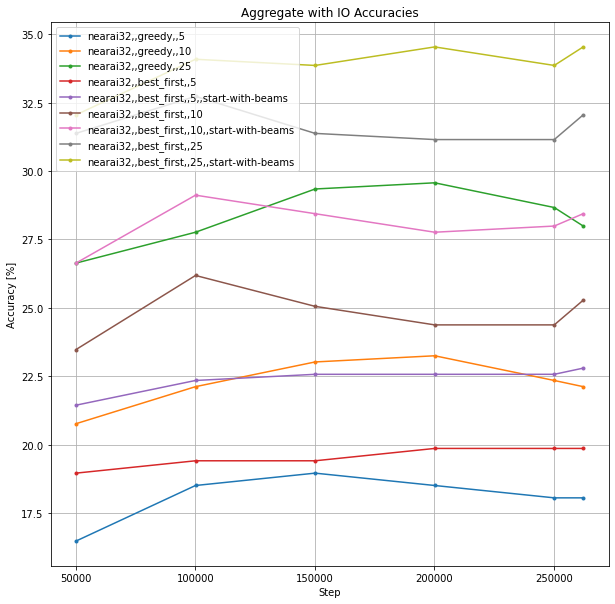

In [24]:
plt.figure(figsize=(10, 10))
plt.title("Aggregate with IO Accuracies")
for strat in "greedy", "best_first":
    for time in 5, 10, 25:
        for start in '', ',,start-with-beams':
            if not (start == '' or strat == 'best_first'):
                continue
            data_source = "nearai32,,{},,{}".format(strat, time) + start
            plot_combined_accuracy(get_accuracies('aggregate-with-io-real-nearai-finetuned-1e-4', 'real', data_source), data_source)
plt.grid()